<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/PINN_1D_Poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics-Informed Neural Networks (PINNs) are a type of neural network that leverages both data and physical laws (represented by differential equations) to model complex systems. They are particularly useful for solving partial differential equations (PDEs), where traditional numerical methods may be computationally expensive or infeasible. PINNs incorporate these physical laws as part of the loss function, allowing the network to not only fit data but also adhere to the governing physics.

### 1D Poisson equation


Physics-Informed Neural Networks (PINNs) are a type of neural network that leverages both data and physical laws (represented by differential equations) to model complex systems. They are particularly useful for solving partial differential equations (PDEs), where traditional numerical methods may be computationally expensive or infeasible. PINNs incorporate these physical laws as part of the loss function, allowing the network to not only fit data but also adhere to the governing physics.

<br>

 **Set Up the Neural Network**
   - **Input:** The network takes the position \( x \) as input.
   - **Output:** The network outputs the value \( u(x) \).
   - The neural network will approximate the solution \( u(x) \).




In [2]:
import tensorflow as tf
import numpy as np

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.output_layer(x)


In [3]:
def f(x):
    return tf.sin(np.pi * x)

def compute_loss(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        physics_loss = u_xx + f(x)

    boundary_loss = tf.square(model(tf.constant([[0.0]]))) + tf.square(model(tf.constant([[1.0]])))

    total_loss = tf.reduce_mean(tf.square(physics_loss)) + boundary_loss
    return total_loss


In [4]:
# Instantiate the model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        x_train = tf.random.uniform([100, 1], 0, 1)  # Sample points
        loss = compute_loss(model, x_train)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')


Epoch 0, Loss: [[0.6603313]]
Epoch 100, Loss: [[0.03489092]]
Epoch 200, Loss: [[0.00812184]]
Epoch 300, Loss: [[0.00761518]]
Epoch 400, Loss: [[0.00734448]]
Epoch 500, Loss: [[0.00742355]]
Epoch 600, Loss: [[0.00624045]]
Epoch 700, Loss: [[0.00427627]]
Epoch 800, Loss: [[0.00262166]]
Epoch 900, Loss: [[0.00237889]]


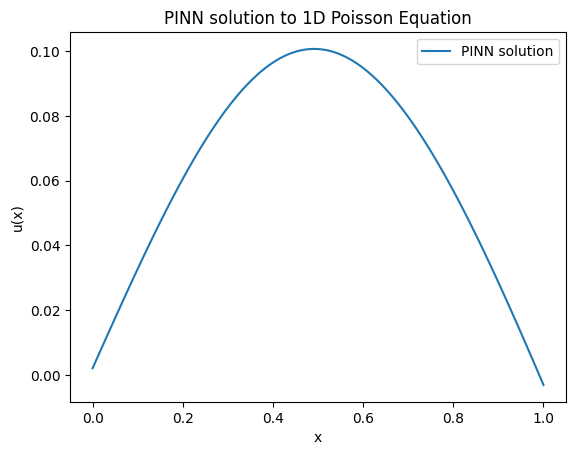

In [5]:
import matplotlib.pyplot as plt

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
u_pred = model(x_test)

plt.plot(x_test, u_pred, label='PINN solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN solution to 1D Poisson Equation')
plt.legend()
plt.show()

## second one

In [6]:
import tensorflow as tf
import numpy as np

# Define the neural network
class SimplePINN(tf.keras.Model):
    def __init__(self):
        super(SimplePINN, self).__init__()
        self.hidden = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden(x)
        return self.output_layer(x)

In [7]:
def compute_loss(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
        u_x = tape.gradient(u, x)
        physics_loss = u_x + u  # u'(x) + u(x) = 0

    initial_condition_loss = tf.square(model(tf.constant([[0.0]])) - 1)  # u(0) = 1

    total_loss = tf.reduce_mean(tf.square(physics_loss)) + initial_condition_loss
    return total_loss

In [8]:
# Instantiate the model and optimizer
model = SimplePINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        x_train = tf.random.uniform([100, 1], 0, 1)  # Sample points in the domain [0, 1]
        loss = compute_loss(model, x_train)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')


Epoch 0, Loss: [[1.1985657]]
Epoch 100, Loss: [[0.24388744]]
Epoch 200, Loss: [[0.03256152]]
Epoch 300, Loss: [[0.03677073]]
Epoch 400, Loss: [[0.02684105]]
Epoch 500, Loss: [[0.02509001]]
Epoch 600, Loss: [[0.02065473]]
Epoch 700, Loss: [[0.01326413]]
Epoch 800, Loss: [[0.01318296]]
Epoch 900, Loss: [[0.00839133]]


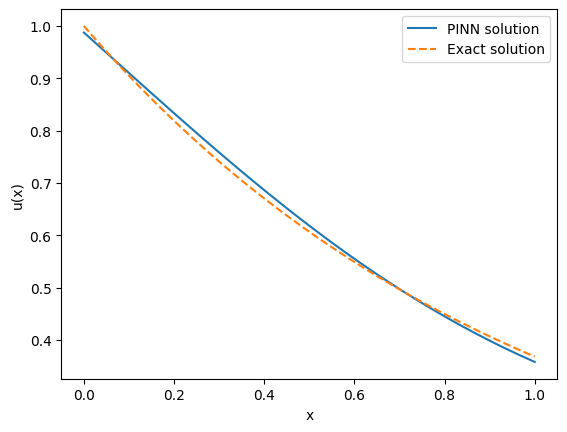

In [9]:
import matplotlib.pyplot as plt

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
u_pred = model(x_test)

plt.plot(x_test, u_pred, label='PINN solution')
plt.plot(x_test, np.exp(-x_test), label='Exact solution', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()